In [1]:

import librosa
import numpy as np
from scipy.signal import lfilter, butter
import decimal
import math
import logging
import scipy.io as sio
import keras.backend as K
from keras.layers import Input, GlobalAveragePooling2D, Reshape,Flatten,Dense,add
from keras.layers.convolutional import Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Lambda, Activation
from keras.models import Model, Sequential
from keras.models import load_model
import os
import pandas as pd
from scipy.spatial.distance import cdist, euclidean, cosine
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import shutil
from tqdm import tqdm
import csv
import random
from statistics import mean
import copy
import numpy as np
import tensorflow as tf
from tensorflow import contrib as loss_metric
import scipy

Using TensorFlow backend.


## Loading Training Data

In [2]:
speakers, n = np.load('details.npy',allow_pickle=True)

In [3]:
training_samples = np.load('training_samples.npy', allow_pickle=True).tolist()

In [4]:
samples_number = [len(i) for i in training_samples]
total_samples = sum(samples_number)
# # Draw the plot
# plt.hist(samples_number,bins = 20,color = '#2F4F4F', edgecolor = 'w')    
# # Title and labels
# plt.title('Number of samples for each speaker')
# plt.xlabel('Number of samples', size = 11)
# plt.ylabel('Frequency', size= 11)

## Forming Triplets

In [5]:
def generate_triplets(data):
    data_copy_1 = copy.deepcopy(data)
    data_copy = copy.deepcopy(data)
    triplets = []
    for speaker in range(n):
        for audio in data_copy_1[speaker]:
            data_copy = copy.deepcopy(data)
            triplet = [audio]
            data_copy[speaker].remove(audio)
            random.shuffle(data_copy[speaker])
            triplet.append(data_copy[speaker].pop(0))
            del data_copy[speaker]
            negative_id = random.randint(0, len(data_copy)-1)
            random.shuffle(data_copy[negative_id])
            triplet.append(data_copy[negative_id].pop(0))
            triplets.append(triplet)
        
    return triplets
    
label_data = copy.deepcopy(training_samples)
triplets_data = generate_triplets(label_data)

In [6]:
check = 0
for i in triplets_data:
    if (i[0][1] == i[1][1]) and (i[0][1] != i[2][1]):
        check +=1
print(total_samples == len(triplets_data) == check)
total_samples

True


75

## Constants

In [7]:

SAMPLE_RATE = 16000
PREEMPHASIS_ALPHA = 0.97
FRAME_LEN = 0.025
FRAME_STEP = 0.01
NUM_FFT = 512
BUCKET_STEP = 1
MAX_SEC = 3

WEIGHTS_FILE = "SavedModel/weights.h5"
# COST_METRIC = "cosine" 
INPUT_SHAPE=(NUM_FFT,300,1)
ROUNDS=2

DURATION = []

## Representation of Audio Data (Speech to Spectrum)

In [8]:
# https://github.com/jameslyons/python_speech_features
# This file includes routines for basic signal processing including framing and computing power spectra.
# Author: James Lyons 2012


def load_wav(filename, sample_rate):
    audio, sr = librosa.load(filename, sr=sample_rate, mono=True)
    audio_length = librosa.get_duration(audio,sr=sr)
    DURATION.append(audio_length)
    audio = audio.flatten()    
    return audio

# https://github.com/christianvazquez7/ivector/blob/master/MSRIT/rm_dc_n_dither.m
def remove_dc_and_dither(sin, sample_rate):
    if sample_rate == 16e3:
        alpha = 0.99
    elif sample_rate == 8e3:
        alpha = 0.999
    sin = lfilter([1,-1], [1,-alpha], sin)
    dither = np.random.random_sample(len(sin)) + np.random.random_sample(len(sin)) - 1
    spow = np.std(dither)
    sout = sin + 1e-6 * spow * dither
    return sout

def preemphasis(signal, coeff=0.95):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

def rolling_window(a, window, step=1):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]


def framesig(sig, frame_len, frame_step, winfunc=lambda x: np.ones((x,)), stride_trick=True):
    
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step)) # LV

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((sig, zeros))
    win = winfunc(frame_len)
    frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    
    return frames * win


def normalize_frames(m,epsilon=1e-12):
    return np.array([(v - np.mean(v)) / max(np.std(v),epsilon) for v in m])

def build_buckets(max_sec, step_sec, frame_step):
    buckets = {}
    frames_per_sec = int(1/frame_step)
    end_frame = int(max_sec*frames_per_sec)
    step_frame = int(step_sec*frames_per_sec)
    for i in range(0, end_frame+1, step_frame):
        s = i
        s = np.floor((s-7+2)/2) + 1  # conv1
        s = np.floor((s-3)/2) + 1  # mpool1
        s = np.floor((s-5+2)/2) + 1  # conv2
        s = np.floor((s-3)/2) + 1  # mpool2
        s = np.floor((s-3+2)/1) + 1  # conv3
        s = np.floor((s-3+2)/1) + 1  # conv4
        s = np.floor((s-3+2)/1) + 1  # conv5
        s = np.floor((s-3)/2) + 1  # mpool5
        s = np.floor((s-1)/1) + 1  # fc6
        s = np.floor((s-1)/1) + 1  
        s = np.floor((s-1)/1) + 1  
        s = np.floor((s-1)/1) + 1  
        if s > 0:
            buckets[i] = int(s)
    return buckets

def get_fft_spectrum(filename):
    buckets = build_buckets(MAX_SEC, BUCKET_STEP, FRAME_STEP)
    signal = load_wav(filename,SAMPLE_RATE)
    signal *= 2**15

    # get FFT spectrum
    signal = remove_dc_and_dither(signal, SAMPLE_RATE)
    signal = preemphasis(signal, coeff=PREEMPHASIS_ALPHA)
    frames = framesig(signal, frame_len=FRAME_LEN*SAMPLE_RATE, frame_step=FRAME_STEP*SAMPLE_RATE, winfunc=np.hamming)
    fft = abs(np.fft.fft(frames,n=NUM_FFT))
    fft_norm = normalize_frames(fft.T)

    # truncate to max bucket sizes
    rsize = max(k for k in buckets if k <= fft_norm.shape[1])
    rstart = int((fft_norm.shape[1]-rsize)/2)
    out = fft_norm[:,rstart:rstart+rsize]

    return out


## Pre-Trained Model

In [9]:
def VGGModel(INP):

    x = ZeroPadding2D(padding=(1,1))(INP)
    x = Conv2D(filters=96,kernel_size=(7,7), strides=(2,2), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(filters=256,kernel_size=(5,5), strides=(2,2), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(filters=384,kernel_size=(3,3), strides=(1,1), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)


    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(filters=256,kernel_size=(3,3), strides=(1,1), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(filters=256,kernel_size=(3,3), strides=(1,1), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(0,0))(x)
    x = Conv2D(filters=4096,kernel_size=(9,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1,1,4096))(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=None)(x)

    x = Lambda(lambda y: K.l2_normalize(y, axis=3))(x)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    
    MODEL = Model(INP, x, name='VGGModel')
    return MODEL

## Triplet Loss Model

In [13]:
def encoder(inp):
    
    base_model = VGGModel(inp)
    base_model.load_weights(WEIGHTS_FILE)

    poppedModel = Model(base_model.input,base_model.layers[-8].output)
    # for i,layer in enumerate(poppedModel.layers):
    #     print(i,layer.name)
    for layer in poppedModel.layers:
        layer.trainable=False

    x = ZeroPadding2D(padding=(1,1))(poppedModel.layers[-1].output)
    x = Conv2D(filters=2048,kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    # x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    # x = Activation('relu')(x) ,kernel_initializer="uniform"
    # x = MaxPooling2D(pool_size=(2,2),strides=None)(x)


    # x = ZeroPadding2D(padding=(1,1))(poppedModel.layers[-1].output)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    # x = BatchNormalization(epsilon=1e-5,momentum=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=None)(x)

    x = Lambda(lambda y: K.l2_normalize(y, axis=3))(x)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid')(x)


    return x


In [15]:
def build_network(encoder,input_shape_1,input_shape_2,input_shape_3):
    
    input_1 = Input(input_shape_1)
    input_2 = Input(input_shape_2)
    input_3 = Input(input_shape_3)
    
    anchor = encoder(input_1)
    positive = encoder(input_2)
    negative = encoder(input_3)
    print('Encoder built!')
    
    model_ = Model(inputs=[input_1, input_2,input_3], outputs=[anchor,positive,negative])

    return model_

In [16]:
def triplet_loss(y_true,y_pred,alpha=0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis = -1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)), axis = -1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(pos_dist - neg_dist + alpha)
#     loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))

    return loss  
  

In [17]:
triplet_loss_model = build_network(encoder,INPUT_SHAPE,INPUT_SHAPE,INPUT_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.
Encoder built!


In [156]:
# triplet_loss_model.summary()

In [18]:
#Compilation
from keras.optimizers import Adam
opt = Adam(lr=0.01)
triplet_loss_model.compile(optimizer =opt,loss=triplet_loss)

## Preparing Training Data

In [19]:
embeddings_df = pd.read_csv('train.csv')
print(embeddings_df.shape)
embeddings_df['Embedding'] = embeddings_df['SampleName'].apply(lambda x: get_fft_spectrum(x))
print(embeddings_df.shape)
embeddings_df.head()

(75, 2)
(75, 3)


,SampleName,Speaker,Embedding
0,data_train/id10003.1.wav,id10003,"[[-0.5712448551183048, -0.6264123611076122, -0..."
1,data_train/id10003.19.wav,id10003,"[[0.9372785176525272, 0.6402701485044744, -0.4..."
2,data_train/id10003.63.wav,id10003,"[[0.6956728562522385, 0.20181905876285386, -0...."
3,data_train/id10003.68.wav,id10003,"[[-0.0506585389249207, -0.9657955561847444, -0..."
4,data_train/id10003.70.wav,id10003,"[[0.3998710348647563, -0.37867003648834, -0.57..."


In [20]:
train_header = ['ID_anchor','emb_anchor','ID_positive','emb_positive','ID_negative','emb_negative']

In [21]:
def get_audio_embeddings(triplets):
    with open('train_triplet_loss.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=train_header)
        writer.writeheader()
        for triplet in triplets:
            row = []
            row.append(triplet[0][1])
            row.append(triplet[0][0])
            row.append(triplet[1][1])
            row.append(triplet[1][0])
            row.append(triplet[2][1])
            row.append(triplet[2][0])            
            writer.writerow(dict(zip(train_header, row)))
            
    train_df = pd.read_csv('train_triplet_loss.csv')    
    return train_df['emb_anchor'],train_df['emb_positive'],train_df['emb_negative']

In [22]:
X_A,X_P,X_N = get_audio_embeddings(triplets_data)

In [23]:
train_df = pd.read_csv('train_triplet_loss.csv')    
train_df.head(5)

,ID_anchor,emb_anchor,ID_positive,emb_positive,ID_negative,emb_negative
0,id10003,data_train/id10003.1.wav,id10003,data_train/id10003.111.wav,id10005,data_train/id10005.30.wav
1,id10003,data_train/id10003.19.wav,id10003,data_train/id10003.70.wav,id10005,data_train/id10005.4.wav
2,id10003,data_train/id10003.63.wav,id10003,data_train/id10003.70.wav,id10005,data_train/id10005.2.wav
3,id10003,data_train/id10003.68.wav,id10003,data_train/id10003.72.wav,id10007,data_train/id10007.19.wav
4,id10003,data_train/id10003.70.wav,id10003,data_train/id10003.136.wav,id10006,data_train/id10006.64.wav


In [24]:
triplet_len = len(triplets_data)
Y = [np.random.rand(1024,).reshape(-1,1024,) for i in range(triplet_len)]
y = [np.array(Y),np.array(Y),np.array(Y)]
buckets = build_buckets(MAX_SEC, BUCKET_STEP, FRAME_STEP)
X_A_emb = list(train_df['emb_anchor'].map(embeddings_df.set_index('SampleName')['Embedding']))
X_P_emb = list(train_df['emb_positive'].map(embeddings_df.set_index('SampleName')['Embedding']))
X_N_emb = list(train_df['emb_negative'].map(embeddings_df.set_index('SampleName')['Embedding']))

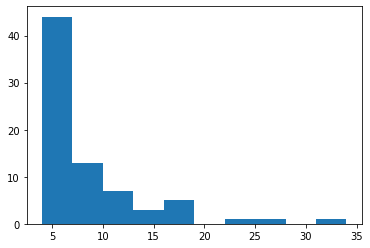

In [25]:
plt.hist(DURATION,bins=10)
plt.show()

In [26]:
print('Min Duration:',min(DURATION),'   Avg Duration:',sum(DURATION)/len(DURATION),'   Max Duration:',max(DURATION))

Min Duration: 4.0000625    Avg Duration: 8.404329166666669    Max Duration: 34.0000625


In [ ]:
triplet_loss_model.fit([np.array(X_A_emb).reshape(-1,512,300,1), np.array(X_P_emb).reshape(-1,512,300,1), np.array(X_N_emb).reshape(-1,512,300,1)],[y[0],y[1],y[2]],epochs=4,batch_size=20)

Epoch 1/4
139/139 [==============================] - ETA: 3:19 - loss: 0.5533 - conv2d_11_loss: 0.1978 - conv2d_22_loss: 0.1990 - conv2d_33_loss: 0.15 - ETA: 2:51 - loss: 0.5883 - conv2d_11_loss: 0.1988 - conv2d_22_loss: 0.2018 - conv2d_33_loss: 0.18 - ETA: 2:13 - loss: 0.6043 - conv2d_11_loss: 0.2024 - conv2d_22_loss: 0.2117 - conv2d_33_loss: 0.19 - ETA: 1:38 - loss: 0.6037 - conv2d_11_loss: 0.2014 - conv2d_22_loss: 0.2085 - conv2d_33_loss: 0.19 - ETA: 1:04 - loss: 0.5816 - conv2d_11_loss: 0.2028 - conv2d_22_loss: 0.1853 - conv2d_33_loss: 0.19 - ETA: 32s - loss: 0.5841 - conv2d_11_loss: 0.2011 - conv2d_22_loss: 0.1876 - conv2d_33_loss: 0.1954 - 241s 2s/step - loss: 0.5953 - conv2d_11_loss: 0.2008 - conv2d_22_loss: 0.1993 - conv2d_33_loss: 0.1952
Epoch 2/4
 20/139 [===>..........................] - ETA: 3:33 - loss: 0.2775 - conv2d_11_loss: 0.2018 - conv2d_22_loss: -0.1442 - conv2d_33_loss: 0.2199

In [ ]:
triplet_loss_model.save('try_model_2.h5')
triplet_loss_model.save_weights('tlm_try_weights.h5')

## Validation and Testing

In [ ]:
val_acc = []
test_acc = []

In [ ]:
def recreate_training_data(speaker, prediction):
    data_val = embeddings_df[['SampleName', 'Speaker','Embedding']]
    size = len(speaker)
    A_VAL = []
    P_VAL = []
    N_VAL = []
    for i in range(size):
        if speaker[i] != prediction[i]:
            for _ in range(2):
                [a,p] = data_val[data_val['Speaker'] == speaker[i]]['Embedding'].sample(2).tolist()
                [n] = data_val[data_val['Speaker'] == prediction[i]]['Embedding'].sample(1).tolist()
                A_VAL.append(a)
                P_VAL.append(p)
                N_VAL.append(n) 
    return A_VAL, P_VAL, N_VAL



def convert_emb_to_vec_train(model, embeddings_df):
    embeddings_df['Vector'] = embeddings_df['Embedding'].apply(lambda x: np.squeeze(encoder_trained.predict(np.array(x).reshape(1,512,300,1))))
    return embeddings_df[['SampleName','Speaker','Vector']]


def convert_emb_to_vec(model, df):
    df['Embedding'] = df['SampleName'].apply(lambda x: get_fft_spectrum(x))
    df['Vector'] = df['Embedding'].apply(lambda x: np.squeeze(encoder_trained.predict(np.array(x).reshape(1,*np.array(x).shape,1))))
    return df[['SampleName','Speaker','Vector']]



In [ ]:
for roundno in range(ROUNDS):
    print('VALIDATION AND TESTING ROUND',roundno+1,'STARTED!')

    print('Loading trained Model....')
    try_model = load_model('try_model_2.h5', custom_objects={'triplet_loss':triplet_loss})
    try_model.load_weights('tlm_try_weights.h5')


    print('Extracting encoder from trained Model...')
    encoder_trained = Model(try_model.layers[0].input,try_model.layers[-3].output)


    print('Processing train samples...')
    train_result = convert_emb_to_vec_train(encoder_trained, embeddings_df)
    trained_vec = np.array([vec.tolist() for vec in train_result['Vector']])
    speakers = train_result['Speaker']


    print('\nProcessing Validation samples...')
    val_df = pd.read_csv('validation.csv')
    val_result = convert_emb_to_vec(encoder_trained, val_df)
    val_vec= np.array([vec.tolist() for vec in val_result['Vector']])

    print("Comparing validation samples against trained samples....")
    distances = pd.DataFrame(cdist(val_vec, trained_vec, metric='euclidean'), columns=speakers)
    val_df = pd.concat([val_df, distances],axis=1)
    val_df['PredictedSpeaker'] = val_df[speakers].idxmin(axis=1)
    val_df['Correct'] = (val_df['PredictedSpeaker'] == val_df['Speaker'])*1. # bool to int
    print('\nNumber of validation samples: ', val_df.shape[0])
    print('Number of correctly predicted speakers: ', sum(val_df['Correct'].tolist()))
    validation_accuracy = sum(val_df['Correct'].tolist())/ val_df.shape[0]
    print('Validation Accuracy:',validation_accuracy)
    val_acc.append(validation_accuracy)

    print('\nAdding triplets...')
    result = val_df[['SampleName','Speaker','PredictedSpeaker', 'Correct']]
    speaker_val = result['Speaker'].tolist()
    prediction_val = result['PredictedSpeaker'].tolist()

    Anchor,Positive,Negative= recreate_training_data(speaker_val, prediction_val)

    X_A_emb = X_A_emb + Anchor
    X_P_emb = X_P_emb + Positive
    X_N_emb = X_N_emb + Negative
    data_size = len(X_A_emb)
    Y = [np.random.rand(1024,).reshape(-1,1024,) for i in range(data_size)]
    y = [np.array(Y),np.array(Y),np.array(Y)]

    print('Retraining the model...')
    triplet_loss_model.fit([np.array(X_A_emb).reshape(-1,512,300,1), np.array(X_P_emb).reshape(-1,512,300,1), np.array(X_N_emb).reshape(-1,512,300,1)],[y[0],y[1],y[2]],epochs=2,batch_size=28)
    print('\nSaving the retrained Model...')
    triplet_loss_model.save('try_model_2.h5')
    triplet_loss_model.save_weights('tlm_try_weights.h5')

    print('\nProcessing Testing samples...')
    test_df = pd.read_csv('test.csv')
    test_result = convert_emb_to_vec(encoder_trained, test_df)
    test_vec= np.array([vec.tolist() for vec in test_result['Vector']])

    print("Comparing test samples against trained samples....")
    distances = pd.DataFrame(cdist(test_vec, trained_vec, metric='euclidean'), columns=speakers)
    test_df = pd.concat([test_df, distances],axis=1)
    test_df['PredictedSpeaker'] = test_df[speakers].idxmin(axis=1)
    test_df['Correct'] = (test_df['PredictedSpeaker'] == test_df['Speaker'])*1. # bool to int
    print('\nNumber of test samples: ', test_df.shape[0])
    print('Number of correctly predicted speakers: ', sum(test_df['Correct'].tolist()))
    test_accuracy = sum(test_df['Correct'].tolist())/ test_df.shape[0]
    print('Test Accuracy:',test_accuracy)
    test_acc.append(test_accuracy)

    print('VALIDATION AND TESTING ROUND',roundno+1,'COMPLETED!\n\n')



In [ ]:
print('Loading trained Model....')
try_model = load_model('try_model_2.h5', custom_objects={'triplet_loss':triplet_loss})
try_model.load_weights('tlm_try_weights.h5')

print('Extracting encoder from trained Model...')
encoder_trained = Model(try_model.layers[0].input,try_model.layers[-3].output)

## Adding New Speaker

In [ ]:
print('Reading New Data...')
newdata = pd.read_csv('newdata.csv')
newdata['Embedding'] = newdata['SampleName'].apply(lambda x: get_fft_spectrum(x))
newdata['Vector'] = newdata['Embedding'].apply(lambda x: np.squeeze(encoder_trained.predict(np.array(x).reshape(1,512,300,1))))

print('Adding New Data...')
newemb = [embeddings_df, newdata]
new_embeddings_df = pd.concat(newemb)
new_embeddings_df.shape[0] == embeddings_df.shape[0] + newdata.shape[0]

## Testing Audio Samples

In [86]:
def test_sample(sample, embeddings_df):

    embedding = get_fft_spectrum(sample)
    vector = np.squeeze(encoder_trained.predict(np.array(embedding).reshape(1,512,300,1)))
    
    embeddings_df['distance'] = embeddings_df['Vector'].apply(lambda x: scipy.spatial.distance.euclidean(x, vector))
    sample_id = embeddings_df.loc[embeddings_df['distance'].idxmin()]
    print(embeddings_df['distance'].tolist())
    embeddings_df = embeddings_df.drop(columns=['distance'])
    print(sample_id['Speaker'])
    return embeddings_df

In [91]:
embeddings_df = test_sample('data_test/id10003.83.wav', embeddings_df)

[2.2427046298980713, 1.802146077156067, 2.125948667526245, 1.8229680061340332, 1.9165761470794678, 1.9137336015701294, 2.0627448558807373, 1.8275219202041626, 1.8857040405273438, 1.8514316082000732, 2.3079757690429688, 2.101149082183838, 1.954125165939331, 2.170279026031494, 1.8406250476837158, 1.9186877012252808, 1.9977394342422485, 1.839442491531372, 2.0090396404266357, 1.9637689590454102, 1.6776297092437744, 1.8362914323806763, 1.7075445652008057, 1.7793054580688477, 1.8177361488342285, 1.661380648612976, 1.7806835174560547, 1.7464728355407715, 1.901174545288086, 2.160890817642212, 1.8956378698349, 1.8700095415115356, 1.8781826496124268, 2.110664129257202, 1.9521498680114746, 1.8839738368988037, 2.1610114574432373, 2.0599677562713623, 1.874345064163208, 2.2109084129333496, 1.8703500032424927, 1.7943518161773682, 1.9382296800613403, 1.8340152502059937, 1.905133605003357, 1.8149921894073486, 1.7418516874313354, 2.097632884979248, 2.038558006286621, 2.036163330078125, 1.782982707023620